# Reference Flare Spectra

Generate reference spectra using some work from Amir Caspi's previous papers (see IDL script). These are then converted from irradiance values to radiance values so that we can use them to simulate MOXSI spectra.

In [1]:
import asdf
import hissw
import astropy.units as u
import numpy as np
from scipy.interpolate import interp1d
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
import ndcube
from ndcube.extra_coords import QuantityTableCoordinate

I got this script from Amir.

In [2]:
idl_script = """
energy_bin_edges = {{ energy_bin_edges | to_unit('keV') | list }}
tmp = get_edges(energy_bin_edges, edges_2=eee, mean=eee_mean, wid=eee_wid)
area = 1
eee_wid = 1
; Calculate various incident photon flux spectra
 ; spec = (phot / cm^2 / s / keV) * keV * cm^2 = phot / s
 ; For 2002 Jul 23, interval 9 (peak HXR) based on Caspi & Lin (2010)
 spec_x5 = (f_vth(eee, [1.27277, 3.63241, 1.0]) + f_vth(eee, [5.40545, 2.02360, 1.0]) + f_vth(eee, [58, 0.52, 1.0]) + f_3pow(eee, [19.9396, 1.50000, 48.1353, 2.65948, 400.000, 2.00000])) * eee_wid * area
; if not keyword_set(filter) then spec_x5[where(eee_mean ge 27.)] = interpol(spec_x5[where(eee_mean ge 20. and eee_mean lt 27.)], eee_mean[where(eee_mean ge 20. and eee_mean lt 27.)], eee_mean[where(eee_mean ge 27.)])
 ; With temps based on Caspi, Krucker, & Lin 2014, EMs adjusted to match GOES flux, and PL adjusted arbitrarily
 spec_m5 = (f_vth(eee, [0.175, 2.75755, 1.0]) + f_vth(eee, [0.6, 1.55112, 1.0]) + f_vth(eee, [5.8, 0.52, 1.0]) + f_3pow(eee, [1.99396, 1.50000, 35, 3.5, 400.000, 2.00000])) * eee_wid * area
 spec_m1 = (f_vth(eee, [0.044, 1.80964, 1.0]) + f_vth(eee, [0.135, 1.29260, 1.0]) + f_vth(eee, [1.2, 0.52, 1.0]) + f_3pow(eee, [0.39879, 1.50000, 20, 4, 400.000, 2.00000])) * eee_wid * area
 ; With temps based on Caspi, Krucker, & Lin 2014 for GOES, guesstimate for RHESSI, EMs adjusted to match GOES flux, and PL adjusted arbitrarily
 spec_c1 = (f_vth(eee, [0.01, 1.2, 1.0]) + f_vth(eee, [0.015, 0.896204, 1.0]) + f_vth(eee, [.08, 0.52, 1.0]) + f_vth(eee, [3.5, 0.2, 0.41]) + f_3pow(eee, [0.04, 1.50000, 15, 6, 400.000, 2.00000])) * eee_wid * area
 ; For strong and weak ARs, based on X123 rocket results of Caspi et al. (2015) -- B7 and B1.6 levels
 spec_b7 = (f_vth(eee, [0.031242997, 0.74194414, 0.41]) + f_vth(eee, [3.5, 0.23129428, 0.41])) * eee_wid * area
 spec_b1 = (f_vth(eee, [0.0014166682, 0.75919482, 1.0]) + f_vth(eee, [0.4, 0.25346233, 1.0])) * eee_wid * area
 spec_a1 = (f_vth(eee, [0.0003, 0.6, 1.0]) + f_vth(eee, [0.07, 0.22, 1.0])) * eee_wid * area
 ; For deep minimum, based on Sylwester et al. (2012)
 spec_min = (f_vth(eee, [0.0978000, 0.147357, 1.0])) * eee_wid * area
 ; Add B7 active-region background to the BIG flares, B1 to the small flare
 spec_x5 += spec_b7 & spec_m5 += spec_b7 & spec_m1 += spec_b7 & spec_c1 += spec_b1
 spec_b1 += spec_min & spec_a1 += spec_min
"""

Run IDL script to generate spectra using `f_vth` and `f_3pow` for an energy range that covers the MOXSI bandpass.

In [3]:
env = hissw.Environment(ssw_paths=['xray'], ssw_packages=['xray'],)
res = env.run(
    idl_script,
    args={
        'energy_bin_edges': np.logspace(-1, np.log10(125), 10000)*u.keV,
    },
    verbose=False,
)
energy_bin_edges = res['energy_bin_edges'] * u.keV
wavelength_bin_edges = energy_bin_edges.to('AA', equivalencies=u.equivalencies.spectral())
for k in res:
    if 'spec' in k:
        res[k] = u.Quantity(res[k], 'ph / (cm2 s keV)')

Look at these spectra in energy space per keV

(1, 1000000000000.0)

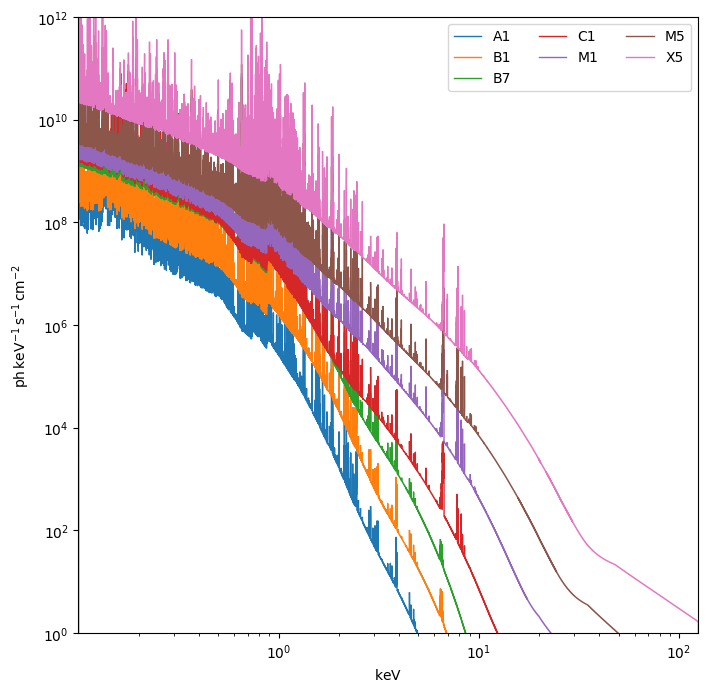

In [4]:
plt.figure(figsize=(8,8))
with quantity_support():
    for goes_class in ['a1', 'b1', 'b7', 'c1', 'm1', 'm5', 'x5']:
        plt.stairs(res[f'spec_{goes_class}'], edges=energy_bin_edges, label=goes_class.upper())
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1,ncol=3)
plt.xlim(energy_bin_edges.min(), energy_bin_edges.max())
plt.ylim(1,1e12)

We need to assume some angular size in order to convert our irradiance to a radiance. We assume a 10"-by-10" size for our flare here.

In [5]:
flare_angular_size = (10*u.arcsec)**2

In [6]:
spectra_collection = []
wavelength_wcs = QuantityTableCoordinate((energy_bin_edges[:-1]+energy_bin_edges[1:])/2, names='energy', physical_types='em.energy').wcs
delta_e_over_delta_wave = np.fabs(np.diff(energy_bin_edges))/np.fabs(np.diff(wavelength_bin_edges))
for goes_class in ['a1', 'b1', 'b7', 'c1', 'm1', 'm5', 'x5']:
    data = res[f'spec_{goes_class}'] * delta_e_over_delta_wave / flare_angular_size.to('sr')
    spectra_collection.append(
        (goes_class, ndcube.NDCube(data.to('ph cm-2 s-1 AA-1 sr-1'), wcs=wavelength_wcs,))
    )
spectra_collection = ndcube.NDCollection(spectra_collection, aligned_axes=(0,),)

Now that we have the radiance values per Angstrom, do a quick sanity check to make sure the values are about what we expect.

(1000000000.0, 1e+19)

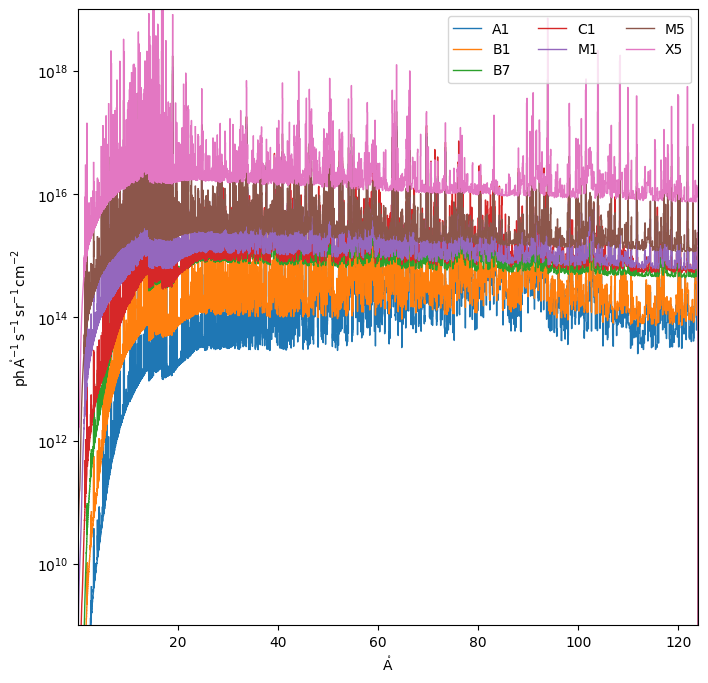

In [7]:
plt.figure(figsize=(8,8))
with quantity_support():
    for k in spectra_collection:
        plt.stairs((spectra_collection[k].data*spectra_collection[k].unit).to('ph AA-1 cm-2 sr-1 s-1'), edges=wavelength_bin_edges, label=k.upper())
plt.yscale('log')
#plt.xscale('log')
plt.legend(loc=1,ncol=3)
plt.xlim(wavelength_bin_edges.min(), wavelength_bin_edges.max())
plt.ylim(1e9,1e19)

Now, save these all out to an ASDF file so we can easily reconstruct the NDCollection later.

In [8]:
tree = {}
for k in spectra_collection:
    tree[k] = {
        'data': spectra_collection[k].data*spectra_collection[k].unit,
        'wcs': spectra_collection[k].wcs,
    }
tree['flare_angular_size'] = flare_angular_size
with asdf.AsdfFile(tree) as af:
    af.write_to('../data/reference_spectra/caspi_flare_spectra.asdf')